In [1]:
# Modified Fork of NCAA competition + AI Lithuania workshop

In [2]:
from sklearn.svm import SVC, SVR, NuSVR, NuSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, brier_score_loss

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import gc

import xgboost as xgb

import statsmodels.api as sm
import tqdm
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import warnings
import catboost as cb
from collections import defaultdict

warnings.filterwarnings("ignore")
pd.set_option("display.max_column", 999)
data_dir = "../input/march-machine-learning-mania-2025"

# W -> women's basketball, M -> men's basketball
M_regular_results = pd.read_csv(f"{data_dir}/MRegularSeasonDetailedResults.csv")
M_tourney_results = pd.read_csv(f"{data_dir}/MNCAATourneyDetailedResults.csv")
M_seeds = pd.read_csv(f"{data_dir}/MNCAATourneySeeds.csv")

W_regular_results = pd.read_csv(f"{data_dir}/WRegularSeasonDetailedResults.csv")
W_tourney_results = pd.read_csv(f"{data_dir}/WNCAATourneyDetailedResults.csv")
W_seeds = pd.read_csv(f"{data_dir}/WNCAATourneySeeds.csv")

In [3]:
# join men's and women's data into one file
regular_results = pd.concat([M_regular_results, W_regular_results])
tourney_results = pd.concat([M_tourney_results, W_tourney_results])
seeds = pd.concat([M_seeds, W_seeds])

In [4]:
season = 2003  # change if you want different cutoff year for your models
regular_results = regular_results.loc[regular_results["Season"] >= season]
tourney_results = tourney_results.loc[tourney_results["Season"] >= season]
seeds = seeds.loc[seeds["Season"] >= season]

## <<- Explore the data ->>

In [5]:
regular_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81703,2025,131,3471,75,3413,66,A,0,26,62,4,19,19,28,8,31,10,11,6,1,20,24,67,9,29,9,14,9,26,14,10,6,5,22
81704,2025,132,3192,66,3476,49,H,0,23,55,3,21,17,18,10,22,11,9,8,1,8,21,57,4,20,3,4,14,22,14,17,4,1,17
81705,2025,132,3250,74,3119,62,H,0,27,45,5,14,15,17,5,25,15,15,6,0,12,25,56,6,17,6,10,8,13,10,10,5,0,20
81706,2025,132,3293,83,3125,62,N,0,28,54,14,28,13,15,5,33,21,13,2,3,15,24,68,2,21,12,14,12,22,11,7,5,0,16


In [6]:
wloc = {'H':1, 'A':-1, 'N': np.nan} #{'H':1, 'A':0, 'N': 0}  # {'H':1, 'A':-1, 'N': 0} #np.nan} #-1}
regular_results['WHome'] = regular_results['WLoc'].map(lambda x: wloc[x])
regular_results['WHome'].value_counts()

WHome
 1.0    114977
-1.0     66045
Name: count, dtype: int64

In [7]:
tourney_results['WHome'] = tourney_results['WLoc'].map(lambda x: wloc[x])
tourney_results['WHome'].value_counts()

WHome
 1.0    294
-1.0     51
Name: count, dtype: int64

In [8]:
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WHome
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,NaN
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,NaN
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,NaN
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,NaN
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,2024,147,3163,80,3425,73,A,0,28,58,7,15,17,27,5,30,17,12,6,5,21,23,70,9,29,18,20,10,25,10,9,6,4,20,-1.0
890,2024,147,3234,94,3261,87,H,0,32,69,13,31,17,22,3,29,16,11,6,3,15,34,88,8,24,11,17,21,28,15,13,6,6,21,1.0
891,2024,151,3234,71,3163,69,N,0,27,59,7,25,10,14,9,23,12,16,7,1,9,29,63,8,25,3,4,6,22,21,14,15,1,18,NaN
892,2024,151,3376,78,3301,59,N,0,33,66,8,19,4,4,10,34,18,15,10,6,16,20,62,6,23,13,18,10,18,5,12,9,1,9,NaN


In [9]:
# let's take one random team and see its journey during the 2024 season
season = 2024
teamid = 3163

r = regular_results.loc[
    (regular_results["Season"] == season)
    & ((regular_results["WTeamID"] == teamid) | (regular_results["LTeamID"] == teamid))
]
t = tourney_results.loc[
    (tourney_results["Season"] == season)
    & ((tourney_results["WTeamID"] == teamid) | (tourney_results["LTeamID"] == teamid))
]
r["win"] = np.where(r["WTeamID"] == teamid, "win", "lose")
t["win"] = np.where(t["WTeamID"] == teamid, "win", "lose")
r["type"] = "regular season"
t["type"] = "tournament"

rt = pd.concat([r, t])
rt[["DayNum", "WScore", "LScore", "type", "win"]]

,DayNum,WScore,LScore,type,win
70978,2,102,58,regular season,win
71162,6,92,81,regular season,lose
71309,10,80,48,regular season,win
71432,13,62,44,regular season,win
71679,18,78,67,regular season,lose
71703,19,71,63,regular season,win
72099,27,80,68,regular season,lose
72161,30,90,63,regular season,win
72306,34,76,64,regular season,win
72433,40,86,62,regular season,win


In [10]:
seeds

,Season,Seed,TeamID
1154,2003,W01,1328
1155,2003,W02,1448
1156,2003,W03,1393
1157,2003,W04,1257
1158,2003,W05,1280
...,...,...,...
1739,2025,Z12,3193
1740,2025,Z13,3251
1741,2025,Z14,3195
1742,2025,Z15,3117


In [11]:
# structure of seeds by division
s = W_seeds.loc[W_seeds["Season"] == 2015]
[s.loc[s["Seed"].str.startswith(d)] for d in ("X", "Y", "Z", "W")]

[      Season Seed  TeamID
 1104    2015  X01    3268
 1105    2015  X02    3397
 1106    2015  X03    3333
 1107    2015  X04    3181
 1108    2015  X05    3280
 1109    2015  X06    3203
 1110    2015  X07    3151
 1111    2015  X08    3343
 1112    2015  X09    3453
 1113    2015  X10    3338
 1114    2015  X11    3211
 1115    2015  X12    3408
 1116    2015  X13    3107
 1117    2015  X14    3355
 1118    2015  X15    3129
 1119    2015  X16    3308,
       Season Seed  TeamID
 1120    2015  Y01    3376
 1121    2015  Y02    3199
 1122    2015  Y03    3113
 1123    2015  Y04    3314
 1124    2015  Y05    3326
 1125    2015  Y06    3401
 1126    2015  Y07    3195
 1127    2015  Y08    3393
 1128    2015  Y09    3304
 1129    2015  Y10    3329
 1130    2015  Y11    3114
 1131    2015  Y12    3241
 1132    2015  Y13    3251
 1133    2015  Y14    3325
 1134    2015  Y15    3106
 1135    2015  Y16    3366,
       Season Seed  TeamID
 1136    2015  Z01    3323
 1137    2015  Z02    3124

In [12]:
# let's see what seed our previous example team had
seeds.loc[(seeds["Season"] == season) & (seeds["TeamID"] == teamid)]

,Season,Seed,TeamID
1660,2024,Z03,3163


## <<- Prepare the data ->>

In [13]:
# double the dataset with swapped team positions in box scores
def prepare_data(df):
    df = df[["Season", "DayNum", "LTeamID", "LScore", "WTeamID", "WScore", "NumOT","WHome",
            "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
            "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]]
    

    # adjustment factor for overtimes, as more stats are accumulated during overtimes
    adjot = (40 + 5 * df["NumOT"]) / 40
    adjcols = ["LScore", "WScore", 
               "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
               "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]
    for col in adjcols:
        df[col] = df[col] / adjot    
    
    dfswap = df.copy()
    df.columns = [x.replace("W", "T1_").replace("L", "T2_") for x in list(df.columns)]
    dfswap.columns = [x.replace("L", "T1_").replace("W", "T2_") for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output["PointDiff"] = output["T1_Score"] - output["T2_Score"]
    output["win"] = (output["PointDiff"] > 0) * 1
    output["men_women"] = (output["T1_TeamID"].apply(lambda t: str(t).startswith("1"))) * 1  # 0: women, 1: men
    return output

regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [14]:
regular_data

,Season,DayNum,T2_TeamID,T2_Score,T1_TeamID,T1_Score,NumOT,T1_Home,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_Home,PointDiff,win,men_women
0,2003,10,1328,62.0,1104,68.0,0,NaN,22.0,53.0,2.0,10.0,16.0,22.0,10.0,22.0,8.0,18.0,9.0,2.0,20.0,27.0,58.0,3.0,14.0,11.0,18.0,14.0,24.0,13.0,23.0,7.0,1.0,22.0,NaN,6.0,1,1
1,2003,10,1393,63.0,1272,70.0,0,NaN,24.0,67.0,6.0,24.0,9.0,20.0,20.0,25.0,7.0,12.0,8.0,6.0,16.0,26.0,62.0,8.0,20.0,10.0,19.0,15.0,28.0,16.0,13.0,4.0,4.0,18.0,NaN,7.0,1,1
2,2003,11,1437,61.0,1266,73.0,0,NaN,22.0,73.0,3.0,26.0,14.0,23.0,31.0,22.0,9.0,12.0,2.0,5.0,23.0,24.0,58.0,8.0,18.0,17.0,29.0,17.0,26.0,15.0,10.0,5.0,2.0,25.0,NaN,12.0,1,1
3,2003,11,1457,50.0,1296,56.0,0,NaN,18.0,49.0,6.0,22.0,8.0,15.0,17.0,20.0,9.0,19.0,4.0,3.0,23.0,18.0,38.0,3.0,9.0,17.0,31.0,6.0,19.0,11.0,12.0,14.0,2.0,18.0,NaN,6.0,1,1
4,2003,11,1208,71.0,1400,77.0,0,NaN,24.0,62.0,6.0,16.0,17.0,27.0,21.0,15.0,12.0,10.0,7.0,1.0,14.0,30.0,61.0,6.0,14.0,11.0,13.0,17.0,22.0,12.0,14.0,4.0,4.0,20.0,NaN,6.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401175,2025,131,3471,75.0,3413,66.0,0,NaN,26.0,62.0,4.0,19.0,19.0,28.0,8.0,31.0,10.0,11.0,6.0,1.0,20.0,24.0,67.0,9.0,29.0,9.0,14.0,9.0,26.0,14.0,10.0,6.0,5.0,22.0,-1.0,-9.0,0,0
401176,2025,132,3192,66.0,3476,49.0,0,NaN,23.0,55.0,3.0,21.0,17.0,18.0,10.0,22.0,11.0,9.0,8.0,1.0,8.0,21.0,57.0,4.0,20.0,3.0,4.0,14.0,22.0,14.0,17.0,4.0,1.0,17.0,1.0,-17.0,0,0
401177,2025,132,3250,74.0,3119,62.0,0,NaN,27.0,45.0,5.0,14.0,15.0,17.0,5.0,25.0,15.0,15.0,6.0,0.0,12.0,25.0,56.0,6.0,17.0,6.0,10.0,8.0,13.0,10.0,10.0,5.0,0.0,20.0,1.0,-12.0,0,0
401178,2025,132,3293,83.0,3125,62.0,0,NaN,28.0,54.0,14.0,28.0,13.0,15.0,5.0,33.0,21.0,13.0,2.0,3.0,15.0,24.0,68.0,2.0,21.0,12.0,14.0,12.0,22.0,11.0,7.0,5.0,0.0,16.0,NaN,-21.0,0,0


In [15]:
tourney_data

,Season,DayNum,T2_TeamID,T2_Score,T1_TeamID,T1_Score,NumOT,T1_Home,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_Home,PointDiff,win,men_women
0,2003,134,1411,74.666667,1421,81.777778,1,NaN,25.777778,59.555556,10.666667,27.555556,12.444444,27.555556,15.111111,24.888889,14.222222,13.333333,4.444444,0.000000,19.555556,28.444444,61.333333,9.777778,25.777778,15.111111,23.111111,12.444444,26.666667,15.111111,10.666667,4.444444,2.666667,19.555556,NaN,7.111111,1,1
1,2003,136,1436,51.000000,1112,80.000000,0,NaN,20.000000,64.000000,4.000000,16.000000,7.000000,7.000000,8.000000,26.000000,12.000000,17.000000,10.000000,3.000000,15.000000,31.000000,66.000000,7.000000,23.000000,11.000000,14.000000,11.000000,36.000000,22.000000,16.000000,10.000000,7.000000,8.000000,NaN,29.000000,1,1
2,2003,136,1272,71.000000,1113,84.000000,0,NaN,25.000000,69.000000,7.000000,28.000000,14.000000,21.000000,20.000000,22.000000,11.000000,12.000000,2.000000,5.000000,18.000000,31.000000,59.000000,6.000000,14.000000,16.000000,22.000000,10.000000,27.000000,18.000000,9.000000,7.000000,4.000000,19.000000,NaN,13.000000,1,1
3,2003,136,1166,73.000000,1141,79.000000,0,NaN,27.000000,60.000000,7.000000,17.000000,12.000000,17.000000,14.000000,17.000000,20.000000,21.000000,6.000000,6.000000,21.000000,29.000000,53.000000,3.000000,7.000000,18.000000,25.000000,11.000000,20.000000,15.000000,18.000000,13.000000,1.000000,19.000000,NaN,6.000000,1,1
4,2003,136,1301,65.777778,1143,67.555556,1,NaN,22.222222,49.777778,8.000000,18.666667,13.333333,17.777778,8.888889,23.111111,14.222222,12.444444,4.444444,7.111111,16.888889,24.000000,56.888889,6.222222,17.777778,13.333333,20.444444,16.000000,17.777778,15.111111,11.555556,7.111111,1.777778,12.444444,NaN,1.777778,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4547,2024,147,3163,80.000000,3425,73.000000,0,NaN,28.000000,58.000000,7.000000,15.000000,17.000000,27.000000,5.000000,30.000000,17.000000,12.000000,6.000000,5.000000,21.000000,23.000000,70.000000,9.000000,29.000000,18.000000,20.000000,10.000000,25.000000,10.000000,9.000000,6.000000,4.000000,20.000000,-1.0,-7.000000,0,0
4548,2024,147,3234,94.000000,3261,87.000000,0,NaN,32.000000,69.000000,13.000000,31.000000,17.000000,22.000000,3.000000,29.000000,16.000000,11.000000,6.000000,3.000000,15.000000,34.000000,88.000000,8.000000,24.000000,11.000000,17.000000,21.000000,28.000000,15.000000,13.000000,6.000000,6.000000,21.000000,1.0,-7.000000,0,0
4549,2024,151,3234,71.000000,3163,69.000000,0,NaN,27.000000,59.000000,7.000000,25.000000,10.000000,14.000000,9.000000,23.000000,12.000000,16.000000,7.000000,1.000000,9.000000,29.000000,63.000000,8.000000,25.000000,3.000000,4.000000,6.000000,22.000000,21.000000,14.000000,15.000000,1.000000,18.000000,NaN,-2.000000,0,0
4550,2024,151,3376,78.000000,3301,59.000000,0,NaN,33.000000,66.000000,8.000000,19.000000,4.000000,4.000000,10.000000,34.000000,18.000000,15.000000,10.000000,6.000000,16.000000,20.000000,62.000000,6.000000,23.000000,13.000000,18.000000,10.000000,18.000000,5.000000,12.000000,9.000000,1.000000,9.000000,NaN,-19.000000,0,0


In [16]:
# let's take an example match to double check if the same match is entered correctly in our dataset
season = regular_data["Season"] == 2025
t1, t2 = 1182, 1433
match1 = (regular_data["T1_TeamID"] == t1) & (regular_data["T2_TeamID"] == t2)
match2 = (regular_data["T1_TeamID"] == t2) & (regular_data["T2_TeamID"] == t1)
regular_data.loc[season & (match1 | match2)]

,Season,DayNum,T2_TeamID,T2_Score,T1_TeamID,T1_Score,NumOT,T1_Home,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_Home,PointDiff,win,men_women
118444,2025,120,1182,62.0,1433,71.0,0,-1.0,21.0,51.0,4.0,16.0,16.0,24.0,11.0,19.0,9.0,15.0,8.0,5.0,16.0,23.0,55.0,8.0,22.0,17.0,21.0,12.0,22.0,10.0,14.0,9.0,4.0,23.0,NaN,9.0,1,1
319034,2025,120,1433,71.0,1182,62.0,0,NaN,23.0,55.0,8.0,22.0,17.0,21.0,12.0,22.0,10.0,14.0,9.0,4.0,23.0,21.0,51.0,4.0,16.0,16.0,24.0,11.0,19.0,9.0,15.0,8.0,5.0,16.0,-1.0,-9.0,0,1


## <<- Easy difficulty features ->>

In [17]:
# extract seed number from `Seed` field
seeds["seed"] = seeds["Seed"].apply(lambda x: int(x[1:3]))
seeds

,Season,Seed,TeamID,seed
1154,2003,W01,1328,1
1155,2003,W02,1448,2
1156,2003,W03,1393,3
1157,2003,W04,1257,4
1158,2003,W05,1280,5
...,...,...,...,...
1739,2025,Z12,3193,12
1740,2025,Z13,3251,13
1741,2025,Z14,3195,14
1742,2025,Z15,3117,15


In [18]:
seeds_T1 = seeds[["Season", "TeamID", "seed"]].copy()
seeds_T2 = seeds[["Season", "TeamID", "seed"]].copy()
seeds_T1.columns = ["Season", "T1_TeamID", "T1_seed"]
seeds_T2.columns = ["Season", "T2_TeamID", "T2_seed"]

tourney_data = tourney_data[["Season", "T1_TeamID", "T2_TeamID", "PointDiff", "win", "men_women"]]
tourney_data = pd.merge(tourney_data, seeds_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, seeds_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data["Seed_diff"] = tourney_data["T2_seed"] - tourney_data["T1_seed"]

tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,men_women,T1_seed,T2_seed,Seed_diff
0,2003,1421,1411,7.111111,1,1,16,16,0
1,2003,1112,1436,29.000000,1,1,1,16,15
2,2003,1113,1272,13.000000,1,1,10,7,-3
3,2003,1141,1166,6.000000,1,1,11,6,-5
4,2003,1143,1301,1.777778,1,1,8,9,1
...,...,...,...,...,...,...,...,...,...
4547,2024,3425,3163,-7.000000,0,0,1,3,2
4548,2024,3261,3234,-7.000000,0,0,3,1,-2
4549,2024,3163,3234,-2.000000,0,0,3,1,-2
4550,2024,3301,3376,-19.000000,0,0,3,1,-2


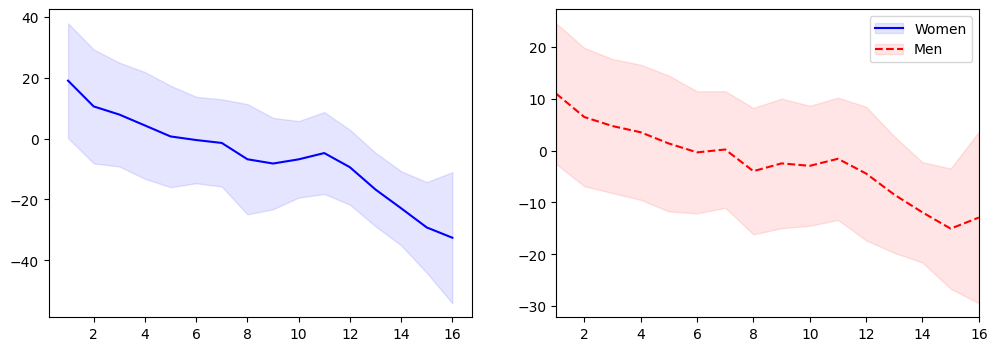

In [19]:
# let's see if __seed__ is predictive for predicting the point difference
tmpmean = tourney_data.pivot_table(columns="men_women", index="T1_seed", values="PointDiff", aggfunc="mean").ffill()
tmpstd = tourney_data.pivot_table(columns="men_women", index="T1_seed", values="PointDiff", aggfunc="std").ffill()
fig, axis = plt.subplots(ncols=2, figsize=(12, 4))
(line_1,) = axis[0].plot(tmpmean.index, tmpmean[0], "b-")
fill_1 = axis[0].fill_between(tmpmean.index, tmpmean[0] - tmpstd[0], tmpmean[0] + tmpstd[0], color="b", alpha=0.1)
(line_2,) = axis[1].plot(tmpmean.index, tmpmean[1], "r--")
fill_2 = axis[1].fill_between(tmpmean.index, tmpmean[1] - tmpstd[1], tmpmean[1] + tmpstd[1], color="r", alpha=0.1)
plt.margins(x=0)
plt.legend([(line_1, fill_1), (line_2, fill_2)], ["Women", "Men"])

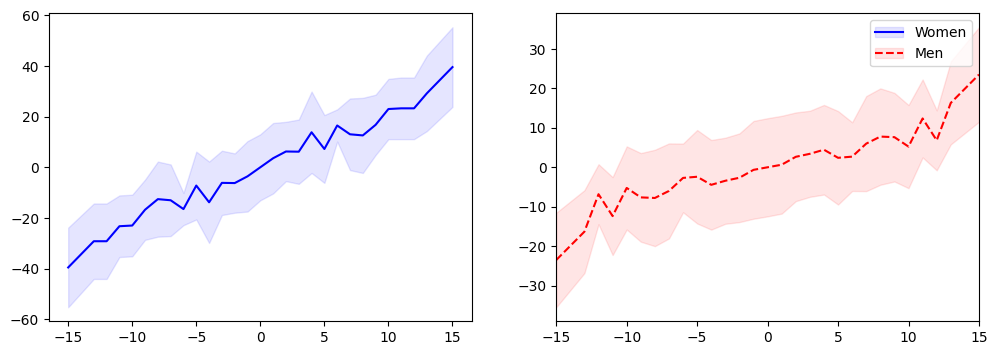

In [20]:
# let's see __seed difference__ is predictive for predicting the point difference
tmpmean = tourney_data.pivot_table(columns="men_women", index="Seed_diff", values="PointDiff", aggfunc="mean").ffill()
tmpstd = tourney_data.pivot_table(columns="men_women", index="Seed_diff", values="PointDiff", aggfunc="std").ffill()
fig, axis = plt.subplots(ncols=2, figsize=(12, 4))
(line_1,) = axis[0].plot(tmpmean.index, tmpmean[0], "b-")
fill_1 = axis[0].fill_between(tmpmean.index, tmpmean[0] - tmpstd[0], tmpmean[0] + tmpstd[0], color="b", alpha=0.1)
(line_2,) = axis[1].plot(tmpmean.index, tmpmean[1], "r--")
fill_2 = axis[1].fill_between(tmpmean.index, tmpmean[1] - tmpstd[1], tmpmean[1] + tmpstd[1], color="r", alpha=0.1)
plt.margins(x=0)
plt.legend([(line_1, fill_1), (line_2, fill_2)], ["Women", "Men"])

## <<- Medium difficulty features ->>

In [21]:
# box score columns, for which we want features to our model
boxcols = [
        "T1_Home","T2_Home",
    "T1_Score", "T1_FGM", "T1_FGA", "T1_FGM3", "T1_FGA3", "T1_FTM", "T1_FTA",
    "T1_OR", "T1_DR", "T1_Ast", "T1_TO", "T1_Stl", "T1_Blk", "T1_PF",
    "T2_Score", "T2_FGM", "T2_FGA", "T2_FGM3", "T2_FGA3", "T2_FTM", "T2_FTA",
    "T2_OR", "T2_DR", "T2_Ast", "T2_TO", "T2_Stl", "T2_Blk", "T2_PF",
    "PointDiff",
]

#### 1. Let's define a single match {**`T`**, **`OPP`**}. This means that **`T=TEAM(x)`** plays against an opponent team **`OPP=TEAM(y1)`**
#### 2. During regular season, team **`T`** plays multiple games {**`T`**, **`OPP1`**}, {**`T`**, **`OPP2`**}, ...; against different opponents **`OPP1=TEAM(y1)`**, **`OPP2=TEAM(y2)`**, ...
#### 3. We can calculate regular season average performance for the team **`T`** : **`average[T]`**
#### 4. We can also calculate how opponents perform on average when they play a game against team **`T`** : **`average[T_OPP1,T_OPP2,...]`**
#### 5. Let's play a new match: {**`T1`**, **`T2`**}
#### 6. We can collect performance data for the **`T1`**: **`average[T1]`** and **`average[T1_OPP1,T1_OPP2,...]`**
#### 7. We can collect performance data for the **`T2`**: **`average[T2]`** and **`average[T2_OPP1,T2_OPP2,...]`**
#### 8. Then we can combine all data: **`average[T1]`**,**`average[T1_OPP1,T1_OPP2,...]`**, **`average[T2]`**, **`average[T2_OPP1,T2_OPP2,...]`**
#### 9. Use this data to predict the output of a match between **`T1`** and **`T2`**

In [22]:
def summarize_cols(x):
    return pd.Series({
                      'WinRatio14d': x['win14days'].sum() /  (1 + x['last14days'].sum()),
                     })

regular_data['win14days'] = (regular_data['DayNum'] > 118) & (regular_data['T1_Score'] > regular_data['T2_Score'])
regular_data['win14days'] = regular_data['win14days'].map(int)
regular_data['last14days'] = (regular_data['DayNum'] > 118).map(int)

ss_new = regular_data.groupby(['Season','T1_TeamID']).apply(summarize_cols, include_groups=False).reset_index()
ss_new['season_team'] = ss_new['Season'].map(str) + '_' + ss_new['T1_TeamID'].map(str)
ratio_dict = dict(zip(ss_new['season_team'].tolist(),ss_new['WinRatio14d'].tolist()))

s = regular_data['Season'].tolist()
t1 = regular_data['T1_TeamID'].tolist()
t2 = regular_data['T2_TeamID'].tolist()
s1 = regular_data['T1_Score'].tolist()
s2 = regular_data['T2_Score'].tolist()
d = defaultdict(lambda: [1,1])
for i in range(len(s)):
    tup = str(s[i])+'_'+str(t1[i])+'_'+str(t2[i])
    if s1[i] > s2[i]:
        d[tup][0] += 1
    else:
        d[tup][1] += 1

match_dict = defaultdict(lambda: 0.5)
for k,v in d.items():
    match_dict[k] = v[0]/v[1]
#print(list(match_dict.items()))
print('done')

l1 = regular_data['T1_TeamID'].tolist()
l2 = regular_data['T2_TeamID'].tolist()
s0 = regular_data['Season'].tolist()
s1 = regular_data['T1_Score'].tolist()
s2 = regular_data['T2_Score'].tolist()
h1 = regular_data['T1_Home'].tolist()
h2 = regular_data['T2_Home'].tolist()

#home_dict = defaultdict()
home_dict = defaultdict(lambda: [0,0]) #1,1])
for i in range(len(l1)):
    k = str(s0[i])+'_'+str(l1[i])
    if s1[i]>s2[i] and h1[i] == -1:
        home_dict[k][0]+= 1 #s1[i] #1
    elif s1[i]<s2[i] and h1[i] == -1:
        home_dict[k][1] += 1 #s2[i] #1

for i in range(len(l2)):
    k = str(s0[i])+'_'+str(l2[i])
    if s1[i]<s2[i] and h2[i] == -1:
        home_dict[k][0]+= 1 # s2[i] #1
    elif s1[i]>s2[i] and h2[i] == -1 :
        home_dict[k][1] += 1 #s1[i] #1

away_dict = {}
for k,v in home_dict.items():
    away_dict[k] = v[0]/(v[0]+v[1])
print('done')

done
done


In [23]:
#regular_data.head(3)
l1 = regular_data['T1_TeamID'].tolist()
l2 = regular_data['T2_TeamID'].tolist()
s0 = regular_data['Season'].tolist()
s1 = regular_data['T1_Score'].tolist()
s2 = regular_data['T2_Score'].tolist()

l_dict = defaultdict(list)
for i in range(len(l1)):
    k = str(s0[i])+'_'+str(l1[i])
    if s1[i]<s2[i]:
        l_dict[k].append(0)
    else:
        l_dict[k].append(1)
        
for i in range(len(l2)):
    k = str(s0[i])+'_'+str(l2[i])
    if s1[i]>s2[i]:
        l_dict[k].append(0)
    else:
        l_dict[k].append(1)

awins_dict = defaultdict(lambda: np.nan)
for k,v in l_dict.items():
    awins_dict[k] = np.mean(l_dict[k])

###

l_dict = defaultdict(list)
for i in range(len(l1)):
    k = str(s0[i])+'_'+str(l1[i])
    if s1[i]<s2[i]:
        l_dict[k].append(0) #-(1-awins_dict[str(s0[i])+'_'+str(l2[i])]))
    else:
        l_dict[k].append(awins_dict[str(s0[i])+'_'+str(l2[i])])
        
for i in range(len(l2)):
    k = str(s0[i])+'_'+str(l2[i])
    if s1[i]>s2[i]:
        l_dict[k].append(0) #-(1-awins_dict[str(s0[i])+'_'+str(l1[i])]))
    else:
        l_dict[k].append(awins_dict[str(s0[i])+'_'+str(l1[i])])

awins_dict = defaultdict(lambda: np.nan)
for k,v in l_dict.items():
    awins_dict[k] = np.mean(l_dict[k])


print('done')


done


In [24]:
# calculate season averages
ss = regular_data.groupby(["Season", "T1_TeamID"])[boxcols].agg("mean").reset_index()

ss_T1 = ss.copy()
ss_T1.columns = ["T1_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T1.columns)]
ss_T1 = ss_T1.rename({"T1_avg_Season": "Season", "T1_avg_TeamID": "T1_TeamID"}, axis=1)

ss_T1['T1_WinRatio14d'] = ss_T1['Season'].map(str) + '_' + ss_T1['T1_TeamID'].map(str)
ss_T1['T1_away_wins'] = ss_T1['T1_WinRatio14d'].map(away_dict)
ss_T1['T1_awins'] = ss_T1['T1_WinRatio14d'].map(awins_dict)
#ss_T1['T1_loss_delta'] = ss_T1['T1_WinRatio14d'].map(loss_delta_dict)
ss_T1['T1_WinRatio14d'] = ss_T1['T1_WinRatio14d'].map(ratio_dict)



ss_T2 = ss.copy()
ss_T2.columns = ["T2_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T2.columns)]
ss_T2 = ss_T2.rename({"T2_avg_Season": "Season", "T2_avg_TeamID": "T2_TeamID"}, axis=1)

ss_T2['T2_WinRatio14d'] = ss_T2['Season'].map(str) + '_' + ss_T2['T2_TeamID'].map(str)
ss_T2['T2_away_wins'] = ss_T2['T2_WinRatio14d'].map(away_dict)
ss_T2['T2_awins'] = ss_T2['T2_WinRatio14d'].map(awins_dict)
#ss_T2['T2_loss_delta'] = ss_T2['T2_WinRatio14d'].map(loss_delta_dict)
ss_T2['T2_WinRatio14d'] = ss_T2['T2_WinRatio14d'].map(ratio_dict)

tourney_data = pd.merge(tourney_data, ss_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, ss_T2, on=["Season", "T2_TeamID"], how="left")

tourney_data['laplace_matchup'] = tourney_data['Season'].map(str)+'_'+tourney_data['T1_TeamID'].map(str)+'_'+tourney_data['T2_TeamID'].map(str)
tourney_data['laplace_matchup'] = tourney_data['laplace_matchup'].map(match_dict)


tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,men_women,T1_seed,T2_seed,Seed_diff,T1_avg_Home,T1_avg_opponent_Home,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,T1_avg_FGA3,T1_avg_FTM,T1_avg_FTA,T1_avg_OR,T1_avg_DR,T1_avg_Ast,T1_avg_TO,T1_avg_Stl,T1_avg_Blk,T1_avg_PF,T1_avg_opponent_Score,T1_avg_opponent_FGM,T1_avg_opponent_FGA,T1_avg_opponent_FGM3,T1_avg_opponent_FGA3,T1_avg_opponent_FTM,T1_avg_opponent_FTA,T1_avg_opponent_OR,T1_avg_opponent_DR,T1_avg_opponent_Ast,T1_avg_opponent_TO,T1_avg_opponent_Stl,T1_avg_opponent_Blk,T1_avg_opponent_PF,T1_avg_PointDiff,T1_WinRatio14d,T1_away_wins,T1_awins,T2_avg_Home,T2_avg_opponent_Home,T2_avg_Score,T2_avg_FGM,T2_avg_FGA,T2_avg_FGM3,T2_avg_FGA3,T2_avg_FTM,T2_avg_FTA,T2_avg_OR,T2_avg_DR,T2_avg_Ast,T2_avg_TO,T2_avg_Stl,T2_avg_Blk,T2_avg_PF,T2_avg_opponent_Score,T2_avg_opponent_FGM,T2_avg_opponent_FGA,T2_avg_opponent_FGM3,T2_avg_opponent_FGA3,T2_avg_opponent_FTM,T2_avg_opponent_FTA,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T2_WinRatio14d,T2_away_wins,T2_awins,laplace_matchup
0,2003,1421,1411,7.111111,1,1,16,16,0,0.666667,0.750000,69.615326,23.847510,55.639847,6.348659,17.658238,15.571648,20.428352,12.011494,22.652874,12.740230,15.931034,6.927969,2.937165,18.769349,76.947893,27.242146,59.712644,7.459004,20.307280,15.004598,22.157854,13.463602,22.401533,15.563218,12.568582,8.679693,4.141762,18.265134,-7.332567,0.750000,1.0,0.174245,0.466667,0.454545,72.533333,24.644444,55.051852,5.911111,18.437037,17.333333,27.929630,13.103704,24.677778,14.140741,15.166667,6.407407,2.222222,18.211111,70.585185,25.581481,60.140741,7.507407,23.051852,11.914815,18.655556,11.881481,22.781481,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148,0.714286,1.0,0.233323,0.5
1,2003,1112,1436,29.000000,1,1,1,16,15,0.120000,0.000000,84.511905,30.067460,65.087302,6.984127,19.857143,17.392857,24.813492,15.051587,27.440476,17.488095,14.666667,8.396825,4.186508,17.587302,69.531746,26.115079,64.107143,6.253968,19.797619,11.047619,17.503968,12.980159,23.067460,15.341270,16.738095,5.904762,2.369048,21.888889,14.980159,0.500000,1.0,0.488861,0.125000,0.750000,67.255172,24.634483,55.427586,5.241379,15.310345,12.744828,19.379310,12.903448,25.565517,14.096552,13.993103,6.841379,2.958621,15.703448,62.565517,22.600000,54.696552,7.034483,21.344828,10.331034,15.482759,9.517241,21.641379,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655,0.750000,1.0,0.255776,0.5
2,2003,1113,1272,13.000000,1,1,10,7,-3,0.500000,0.333333,75.344828,27.003831,56.436782,3.977011,12.475096,17.360153,25.877395,13.501916,23.111111,15.448276,13.881226,5.164751,4.191571,19.260536,68.574713,24.574713,55.176245,5.398467,15.766284,14.026820,20.375479,10.931034,20.367816,13.946360,15.402299,5.950192,3.908046,22.624521,6.770115,0.500000,1.0,0.296382,0.333333,0.333333,74.210728,26.183908,59.762452,6.969349,19.996169,14.873563,22.766284,14.019157,25.846743,16.555556,13.739464,7.363985,5.042146,18.693487,65.517241,23.164751,57.593870,5.854406,18.218391,13.333333,20.659004,12.295019,23.482759,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487,0.600000,1.0,0.388420,0.5
3,2003,1141,1166,6.000000,1,1,11,6,-5,0.100000,0.666667,79.344828,26.620690,52.689655,6.827586,17.931034,19.275862,25.172414,10.586207,23.275862,15.620690,18.241379,7.103448,4.000000,20.965517,73.241379,26.344828,57.931034,4.965517,13.896552,15.586207,21.965517,12.241379,18.896552,11.793103,16.068966,8.448276,2.482759,21.689655,6.103448,0.833333,1.0,0.372517,0.416667,1.000000,79.006734,28.619529,57.289562,7.942761,20.424242,13.824916,19.952862,10.848485,23.097643,16.784512,13.309764,8.370370,4.427609,17.205387,64.107744,23.797980,55.148148,4.868687,14.282828,11.643098,16.619529,11.020202,21.289562,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990,0.800000,1.0,0.411432,0.5
4,2003,1143,1301,1.777778,1,1,8,9,1,0.300000,0.600000,73.636015,27.015326,57.946360,6.314176,16.789272,13.29

## <<- Hard difficulty features ->>

In [25]:
def update_elo(winner_elo, loser_elo):
    expected_win = expected_result(winner_elo, loser_elo)
    change_in_elo = k_factor * (1 - expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo


def expected_result(elo_a, elo_b):
    return 1.0 / (1 + 10 ** ((elo_b - elo_a) / elo_width))

base_elo = 1000
elo_width = 400
k_factor = 100

elos = []
for season in sorted(set(seeds["Season"])):
    ss = regular_data.loc[regular_data["Season"] == season]
    ss = ss.loc[ss["win"] == 1].reset_index(drop=True)
    teams = set(ss["T1_TeamID"]) | set(ss["T2_TeamID"])
    elo = dict(zip(teams, [base_elo] * len(teams)))
    for i in range(ss.shape[0]):
        w_team, l_team = ss.loc[i, "T1_TeamID"], ss.loc[i, "T2_TeamID"]
        w_elo, l_elo = elo[w_team], elo[l_team]
        w_elo_new, l_elo_new = update_elo(w_elo, l_elo)
        elo[w_team] = w_elo_new
        elo[l_team] = l_elo_new
    elo = pd.DataFrame.from_dict(elo, orient="index").reset_index()
    elo = elo.rename({"index": "TeamID", 0: "elo"}, axis=1)
    elo["Season"] = season
    elos.append(elo)
elos = pd.concat(elos)

elos_T1 = elos.copy().rename({"TeamID": "T1_TeamID", "elo": "T1_elo"}, axis=1)
elos_T2 = elos.copy().rename({"TeamID": "T2_TeamID", "elo": "T2_elo"}, axis=1)
tourney_data = pd.merge(tourney_data, elos_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, elos_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data["elo_diff"] = tourney_data["T1_elo"] - tourney_data["T2_elo"]

<Axes: xlabel='elo'>

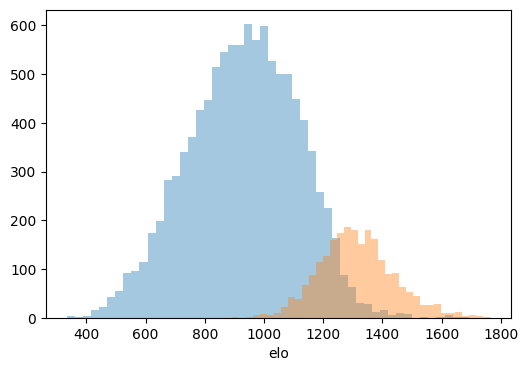

In [26]:
tmp = pd.merge(elos, tourney_data[['Season', 'T1_TeamID']].drop_duplicates(), 
               left_on = ['Season', 'TeamID'], 
               right_on = ['Season', 'T1_TeamID'],
               how = 'left')

plt.figure(figsize=(6,4))
seaborn.distplot(tmp.loc[pd.isnull(tmp['T1_TeamID']),'elo'], kde=False)
seaborn.distplot(tmp.loc[~pd.isnull(tmp['T1_TeamID']),'elo'], kde=False)

<Axes: xlabel='T1_seed', ylabel='T1_elo'>

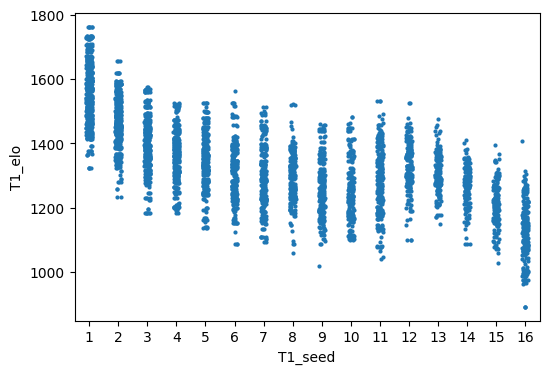

In [27]:
plt.figure(figsize=(6,4))
seaborn.stripplot(data = tourney_data, y = 'T1_elo', x = 'T1_seed', size=3)

<Axes: xlabel='Seed_diff', ylabel='elo_diff'>

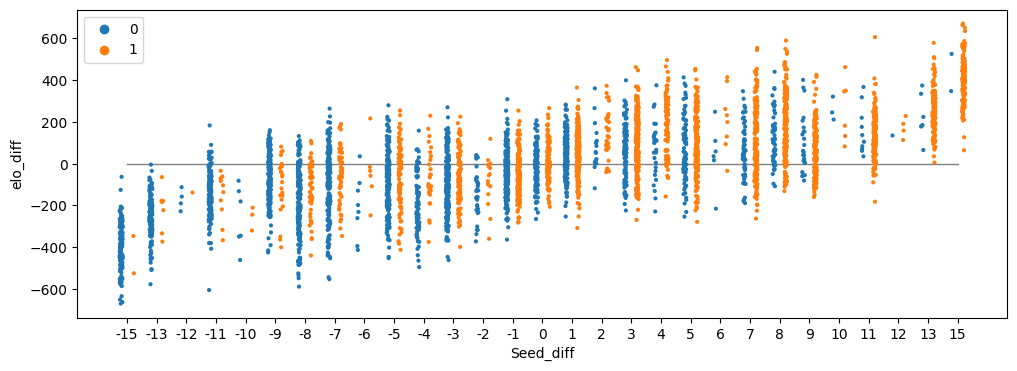

In [28]:
plt.figure(figsize=(12,4))
seaborn.stripplot(data = tourney_data, y = 'elo_diff', x = 'Seed_diff', hue='win', dodge=True, size=3)
seaborn.lineplot([0]*29,color='gray',lw = 1)

## <<- Hardest difficulty features ->>

In [29]:


regular_data["ST1"] = regular_data.apply(lambda t: str(int(t["Season"])) + "/" + str(int(t["T1_TeamID"])), axis=1)
regular_data["ST2"] = regular_data.apply(lambda t: str(int(t["Season"])) + "/" + str(int(t["T2_TeamID"])), axis=1)
seeds_T1["ST1"] = seeds_T1.apply(lambda t: str(int(t["Season"])) + "/" + str(int(t["T1_TeamID"])), axis=1)
seeds_T2["ST2"] = seeds_T2.apply(lambda t: str(int(t["Season"])) + "/" + str(int(t["T2_TeamID"])), axis=1)

# collect tourney teams
st = set(seeds_T1["ST1"]) | set(seeds_T2["ST2"])
# append non-tourney teams which were able to beat tourney team at least once
st = st | set(regular_data.loc[(regular_data["T1_Score"] > regular_data["T2_Score"]) & 
                               (regular_data["ST2"].isin(st)), "ST1"])

def team_quality(season, men_women):
    # mixed effects: fixed intercept=0, random slope
    formula = "PointDiff~-1+T1_TeamID+T2_TeamID"
    glm = sm.GLM.from_formula(
        formula=formula,
        data=dt.loc[(dt["Season"] == season) & (dt["men_women"] == men_women), :],
        family=sm.families.Gaussian(),
    ).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ["TeamID", "quality"]
    quality["quality"] = quality["quality"]
    quality["Season"] = season
    quality = quality.loc[quality.TeamID.str.contains("T1_")].reset_index(drop=True)
    quality["TeamID"] = quality["TeamID"].apply(lambda x: x[10:14]).astype(int)
    return quality


glm_quality = []

dt = regular_data.loc[regular_data["ST1"].isin(st) | regular_data["ST2"].isin(st)]
dt["T1_TeamID"] = dt["T1_TeamID"].astype(str)
dt["T2_TeamID"] = dt["T2_TeamID"].astype(str)
dt.loc[~dt["ST1"].isin(st), "T1_TeamID"] = "0000"
dt.loc[~dt["ST2"].isin(st), "T2_TeamID"] = "0000"
seasons = sorted(set(seeds["Season"]))
for s in tqdm.tqdm(seasons, unit="season"):
    if s >= 2010:  # min season for women
        glm_quality.append(team_quality(s, 0))
    if s >= 2003:  # min season for men
        glm_quality.append(team_quality(s, 1))

glm_quality = pd.concat(glm_quality).reset_index(drop=True)

glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ["T1_TeamID", "T1_quality", "Season"]
glm_quality_T2.columns = ["T2_TeamID", "T2_quality", "Season"]
tourney_data = pd.merge(tourney_data, glm_quality_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, glm_quality_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data["diff_quality"] = tourney_data["T1_quality"] - tourney_data["T2_quality"]

100%|██████████| 22/22 [01:28<00:00,  4.02s/season]


<Axes: ylabel='T1_quality'>

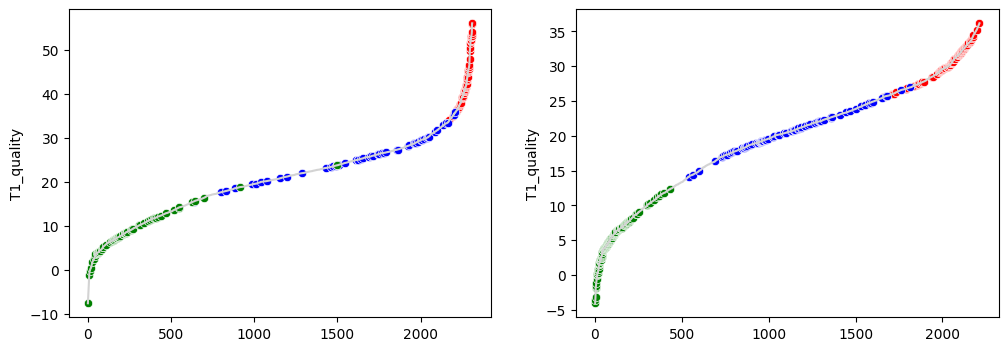

In [30]:
tmp = (
    tourney_data[["Season", "men_women", "T1_seed", "T1_quality"]]
    .drop_duplicates()
    .sort_values("T1_quality")
    .reset_index(drop=True)
)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

seaborn.lineplot(tmp.loc[tmp["men_women"] == 0, "T1_quality"], color="lightgray", ax=axs[0])
seaborn.scatterplot(tmp.loc[(tmp["men_women"] == 0) & (tmp.T1_seed == 1), "T1_quality"], color="red", ax=axs[0])
seaborn.scatterplot(tmp.loc[(tmp["men_women"] == 0) & (tmp.T1_seed == 7), "T1_quality"], color="blue", ax=axs[0])
seaborn.scatterplot(tmp.loc[(tmp["men_women"] == 0) & (tmp.T1_seed == 16), "T1_quality"], color="green", ax=axs[0])

seaborn.lineplot(tmp.loc[tmp["men_women"] == 1, "T1_quality"], color="lightgray", ax=axs[1])
seaborn.scatterplot(tmp.loc[(tmp["men_women"] == 1) & (tmp.T1_seed == 1), "T1_quality"], color="red", ax=axs[1])
seaborn.scatterplot(tmp.loc[(tmp["men_women"] == 1) & (tmp.T1_seed == 7), "T1_quality"], color="blue", ax=axs[1])
seaborn.scatterplot(tmp.loc[(tmp["men_women"] == 1) & (tmp.T1_seed == 16), "T1_quality"], color="green", ax=axs[1])

In [31]:
tmp["QualitySeed"] = (
    (tmp.groupby(["Season", "men_women"])["T1_quality"].rank(ascending=False) // 4 + 1).clip(1, 16).astype(int)
)
pd.pivot_table(data=tmp, index="T1_seed", columns="QualitySeed", values="men_women", aggfunc="count").fillna(0).astype(int).style.bar(color="#5fba7d", vmin=0, vmax=50)

QualitySeed,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
T1_seed,,,,,,,,,,,,,,,,
1,75,45,12,4,1,1,1,0,1,0,0,0,0,0,0,0
2,18,49,42,20,5,4,2,0,0,0,0,0,0,0,0,0
3,6,16,33,30,26,16,5,3,0,4,1,0,0,0,0,0
4,5,15,22,25,18,21,19,9,3,2,1,0,0,0,0,0
5,0,6,14,25,20,19,22,14,7,4,7,2,0,0,0,0
6,1,3,7,13,23,29,14,19,10,10,6,4,1,0,0,0
7,0,2,3,6,18,12,19,22,22,14,12,8,2,0,0,0
8,0,0,3,6,6,17,19,20,19,22,15,6,7,0,0,0
9,0,2,0,6,10,7,12,17,25,24,19,11,5,1,1,0


In [32]:


print("Seed AUC    :", np.round(roc_auc_score(1 - tourney_data["win"], tourney_data["T1_seed"] - tourney_data["T2_seed"]), 3))
print("Quality AUC :", np.round(roc_auc_score(tourney_data["win"], tourney_data["T1_quality"] - tourney_data["T2_quality"]), 3))

Seed AUC    : 0.807
Quality AUC : 0.825


In [33]:
# who is better, experts or statistics, by season
for s in sorted(set(tourney_data['Season'])):
    st = tourney_data['Season'] == s
    print(s, 
          a:=np.round(roc_auc_score(1-tourney_data.loc[st, "win"],tourney_data.loc[st, 'T1_seed'] - tourney_data.loc[st, 'T2_seed']),3),
          b:=np.round(roc_auc_score(tourney_data.loc[st, "win"],tourney_data.loc[st, 'T1_quality'] - tourney_data.loc[st, 'T2_quality']),3),
          np.where(a>b, '', 'Q')
         )

2003 0.807 0.779 
2004 0.823 0.81 
2005 0.792 0.811 Q
2006 0.75 0.781 Q
2007 0.902 0.838 
2008 0.817 0.851 Q
2009 0.84 0.843 Q
2010 0.804 0.808 Q
2011 0.789 0.816 Q
2012 0.828 0.855 Q
2013 0.792 0.819 Q
2014 0.779 0.816 Q
2015 0.85 0.87 Q
2016 0.787 0.825 Q
2017 0.842 0.851 Q
2018 0.786 0.794 Q
2019 0.85 0.88 Q
2021 0.78 0.818 Q
2022 0.77 0.794 Q
2023 0.781 0.793 Q
2024 0.839 0.839 Q


## <<- Machine Learning model ->>

In [34]:


cat_features = [
    "T1_avg_FGM",
    "T1_avg_FGM3",
    "T1_avg_FGA3",
    "T1_avg_FTM",
    "T1_avg_FTA",
    "T1_avg_OR",
    "T1_avg_DR",
    "T1_avg_Ast",
    "T1_avg_TO",
    "T1_avg_Stl",
    "T1_avg_opponent_Score",
    "T1_avg_opponent_FGM",
    "T1_avg_opponent_FGM3",
    "T1_avg_opponent_FGA3",
    "T1_avg_opponent_FTM",
    "T1_avg_opponent_FTA",
    "T1_avg_opponent_OR",
    "T1_avg_opponent_DR",
    "T1_avg_opponent_Ast",
    "T1_avg_opponent_TO",
    "T1_avg_opponent_Stl",
    "T2_avg_FGM",
    "T2_avg_FGM3",
    "T2_avg_FGA3",
    "T2_avg_FTM",
    "T2_avg_FTA",
    "T2_avg_OR",
    "T2_avg_DR",
    "T2_avg_Ast",
    "T2_avg_TO",
    "T2_avg_Stl",
    "T2_avg_opponent_Score",
    "T2_avg_opponent_FGM",
    "T2_avg_opponent_FGM3",
    "T2_avg_opponent_FGA3",
    "T2_avg_opponent_FTM",
    "T2_avg_opponent_FTA",
    "T2_avg_opponent_OR",
    "T2_avg_opponent_DR",
    "T2_avg_opponent_Ast",
    "T2_avg_opponent_TO",
    "T2_avg_opponent_Stl",    
]
np.random.seed(0)
cb_model1a = make_pipeline(StandardScaler(), NuSVC(probability=True, nu = 0.6, kernel = 'poly', gamma='scale', degree=2))
cb_model1b = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=100, weights='uniform', p=2, metric='minkowski'))

x_train = tourney_data.loc[tourney_data[ "men_women"] == 1, cat_features].values
y_train = tourney_data.loc[tourney_data[ "men_women"] == 1, "PointDiff"].values
y_train1 = (y_train > 0) *1.0
cb_model1a.fit(x_train, y_train1)
cb_model1b.fit(x_train, y_train)

x_test = tourney_data.loc[tourney_data[ "men_women"] != 1, cat_features].values

preds1a = cb_model1a.predict_proba(x_test)[:,1]
preds1b = cb_model1b.predict(x_test)
###################################

cb_model2a = make_pipeline(StandardScaler(), NuSVC(probability=True, nu = 0.6, kernel = 'poly', gamma='scale', degree=2))
cb_model2b = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=100, weights='uniform', p=2, metric='minkowski'))
x_train = tourney_data.loc[tourney_data[ "men_women"] != 1, cat_features].values
y_train = tourney_data.loc[tourney_data[ "men_women"] != 1, "PointDiff"].values
y_train2 = (y_train > 0) *1.0
cb_model2a.fit(x_train, y_train2)
cb_model2b.fit(x_train, y_train)

x_test = tourney_data.loc[tourney_data[ "men_women"] == 1, cat_features].values

preds2a = cb_model2a.predict_proba(x_test)[:,1]
preds2b = cb_model2b.predict(x_test)

In [35]:
tourney_data['cb_preds1'] = np.nan
tourney_data.loc[tourney_data[ "men_women"] == 1, 'cb_preds1'] = preds2a
tourney_data.loc[tourney_data[ "men_women"] != 1, 'cb_preds1'] = preds1a
tourney_data['cb_preds1'].describe()

tourney_data['cb_preds2'] = np.nan
tourney_data.loc[tourney_data[ "men_women"] == 1, 'cb_preds2'] = preds2b
tourney_data.loc[tourney_data[ "men_women"] != 1, 'cb_preds2'] = preds1b
tourney_data['cb_preds2'].describe()

count    4552.000000
mean        0.000000
std         3.708144
min       -13.625556
25%        -2.373000
50%         0.000000
75%         2.373000
max        13.625556
Name: cb_preds2, dtype: float64

In [36]:
features = [
    ### EASY FEATURES ###
    "men_women",    
    "T1_seed",
    "T2_seed",
    "Seed_diff",
    ### MEDIUM FEATURES ###
    "T1_avg_Score",
    "T1_avg_FGA",
    "T1_awins", "T2_awins",
    "T1_away_wins","T2_away_wins",
    "laplace_matchup",
    "T1_WinRatio14d",
    "T2_WinRatio14d",
    "cb_preds1","cb_preds2",
    "T1_avg_Blk",
    "T1_avg_PF",
    "T1_avg_opponent_FGA",
    "T1_avg_opponent_Blk",
    "T1_avg_opponent_PF",
    "T1_avg_PointDiff",
    "T2_avg_Score",
    "T2_avg_FGA",
    "T2_avg_Blk",
    "T2_avg_PF",
    "T2_avg_opponent_FGA",
    "T2_avg_opponent_Blk",
    "T2_avg_opponent_PF",
    "T2_avg_PointDiff",
    ### HARD FEATURES ###
    "T1_elo",
    "T2_elo",    
    "elo_diff",
    ### HARDEST FEATURES ###
    "T1_quality",
    "T2_quality",
]

print(f"Number of features {len(features)}")

Number of features 34


In [37]:


param = {}
param["objective"] = "reg:squarederror"
param["booster"] = "gbtree"
param["eta"] = 0.01
param["subsample"] = 0.6
param["colsample_bynode"] = 0.8
param["num_parallel_tree"] = 2
param["min_child_weight"] = 4
param["max_depth"] = 4
param["tree_method"] = "hist"
param['grow_policy'] = 'lossguide'
param["max_bin"] = 32

num_rounds = 700

def cauchyobj(preds, dtrain): 
  labels = dtrain.get_label()
  c = 5000 
  x =  preds-labels
  x2 = x**2
  c2 = c**2
  grad = x / (x2/c2+1)
  hess = -c2*(x2-c2)/(x2+c2)**2
  return grad, hess



xgb_parameters = {
    'eval_metric': 'mae',
    'eta': 0.02,
    'subsample': 0.35,
    'colsample_bytree': 0.7,
    'num_parallel_tree': 10,
    'min_child_weight': 40,
    'max_depth': 4, #worse at both 3,5,
    'gamma': 10,
}

In [38]:


models = {}
oof_mae = []
oof_preds = []
oof_targets = []
oof_ss = []

# leave-one-season out models
for oof_season in set(tourney_data.Season):
    x_train = tourney_data.loc[tourney_data["Season"] != oof_season, features].values
    y_train = tourney_data.loc[tourney_data["Season"] != oof_season, "PointDiff"].values
    x_val = tourney_data.loc[tourney_data["Season"] == oof_season, features].values
    y_val = tourney_data.loc[tourney_data["Season"] == oof_season, "PointDiff"].values
    s_val = tourney_data.loc[tourney_data["Season"] == oof_season, "Season"].values
    
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, label=y_val)

    models[oof_season] = xgb.train(
      params = xgb_parameters,
      dtrain = dtrain,
      num_boost_round = 400, 
      obj = cauchyobj,
    )
    
    preds = models[oof_season].predict(dval)
    print(f"oof season {oof_season} mae: {mean_absolute_error(y_val, preds)}")
    oof_mae.append(mean_absolute_error(y_val, preds))
    oof_preds += list(preds)
    oof_targets += list(y_val)
    oof_ss += list(s_val)
    
print(f"average mae: {np.mean(oof_mae)}")

oof season 2003 mae: 8.708951950647558
oof season 2004 mae: 7.821233548333273
oof season 2005 mae: 7.829842060561189
oof season 2006 mae: 8.334836765610978
oof season 2007 mae: 7.660660189316452
oof season 2008 mae: 9.6568889517156
oof season 2009 mae: 9.363238150140063
oof season 2010 mae: 8.588177627269978
oof season 2011 mae: 9.654524475862312
oof season 2012 mae: 8.2649253284288
oof season 2013 mae: 9.956479998210975
oof season 2014 mae: 9.929650067800702
oof season 2015 mae: 7.963608352744427
oof season 2016 mae: 10.140461714550153
oof season 2017 mae: 9.928790670882863
oof season 2018 mae: 10.386985452590972
oof season 2019 mae: 8.982330932552154
oof season 2021 mae: 10.41418262124928
oof season 2022 mae: 10.289944207149976
oof season 2023 mae: 9.309885111180634
oof season 2024 mae: 9.475474593465897
average mae: 9.174336798584008


In [39]:


def make_strings(x):
    output_list = []
    for i in range(x.shape[0]):
        tmp_str = ''
        for j in range(x.shape[1]):
            tmp_str += str(j)+'_'+ str(int(x[i][j])) + ' '
        output_list.append(tmp_str)
    return output_list



In [40]:



brier_list = []
logistic_dict = dict()
# leave-one-season out models
for oof_season in set(tourney_data.Season):
    gc.collect()
    x_train = tourney_data.loc[tourney_data["Season"] != oof_season, features].values
    y_train = tourney_data.loc[tourney_data["Season"] != oof_season, "PointDiff"].values
    x_val = tourney_data.loc[tourney_data["Season"] == oof_season, features].values
    y_val = tourney_data.loc[tourney_data["Season"] == oof_season, "PointDiff"].values
    s_val = tourney_data.loc[tourney_data["Season"] == oof_season, "Season"].values
    
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, label=y_val)
    
    tmp = models[oof_season].predict(dtrain, pred_leaf=True)
    tmp = make_strings(tmp)
    calibrater = make_pipeline(TfidfVectorizer(), LogisticRegression(solver='liblinear',random_state =0,max_iter=300))
                                                                    # penalty='elasticnet', l1_ratio=0.5)) #penalty=None bad
    y_val_bin = (y_train>0)*1
    calibrater.fit(tmp, y_val_bin)
    logistic_dict[oof_season] = calibrater
    
    tmp = models[oof_season].predict(dval, pred_leaf=True)
    tmp = make_strings(tmp)
    preds = calibrater.predict_proba(tmp)[:,1]
    y_val_bin = (y_val>0)*1
    bscore = brier_score_loss(y_val_bin, preds)
    brier_list.append(bscore)
    print(f"oof season {oof_season} brier: {bscore}")


np.mean(brier_list)

oof season 2003 brier: 0.18780493082168265
oof season 2004 brier: 0.1737221161113439
oof season 2005 brier: 0.16802974874227167
oof season 2006 brier: 0.19176772951315246
oof season 2007 brier: 0.14686017825335368
oof season 2008 brier: 0.14771686402047668
oof season 2009 brier: 0.17251482282168026
oof season 2010 brier: 0.16618202753747296
oof season 2011 brier: 0.1859135003565886
oof season 2012 brier: 0.15713804695873157
oof season 2013 brier: 0.16579038642837166
oof season 2014 brier: 0.17717915286710625
oof season 2015 brier: 0.14824551427857693
oof season 2016 brier: 0.17353188522490207
oof season 2017 brier: 0.15846139076009885
oof season 2018 brier: 0.18228466879258745
oof season 2019 brier: 0.1444325482666925
oof season 2021 brier: 0.17933069184103514
oof season 2022 brier: 0.18857278544036288
oof season 2023 brier: 0.18267623353255158
oof season 2024 brier: 0.16593335062665648


0.16971850348550935

## <<- Make submission ->>

In [41]:
##################################################################################
#### Stage2 data should be available on March 17, check forums for updates #######
##################################################################################

X = pd.read_csv(f"{data_dir}/SampleSubmissionStage2.csv")
X

,ID,Pred
0,2025_1101_1102,0.5
1,2025_1101_1103,0.5
2,2025_1101_1104,0.5
3,2025_1101_1105,0.5
4,2025_1101_1106,0.5
...,...,...
131402,2025_3477_3479,0.5
131403,2025_3477_3480,0.5
131404,2025_3478_3479,0.5
131405,2025_3478_3480,0.5


In [42]:
# construct dataframe for submission
X['Season'] = X['ID'].apply(lambda t: int(t.split('_')[0]))
X['T1_TeamID'] = X['ID'].apply(lambda t: int(t.split('_')[1]))
X['T2_TeamID'] = X['ID'].apply(lambda t: int(t.split('_')[2]))
X['men_women'] = X['T1_TeamID'].apply(lambda t: 0 if str(t)[0]=='1' else 1)
X = pd.merge(X, ss_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, ss_T2, on = ['Season', 'T2_TeamID'], how = 'left')
X = pd.merge(X, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
X = pd.merge(X, glm_quality_T1, on=["Season", "T1_TeamID"], how="left")
X = pd.merge(X, glm_quality_T2, on=["Season", "T2_TeamID"], how="left")
X = pd.merge(X, elos_T1, on=["Season", "T1_TeamID"], how="left")
X = pd.merge(X, elos_T2, on=["Season", "T2_TeamID"], how="left")
X["Seed_diff"] = X["T2_seed"] - X["T1_seed"]
X["elo_diff"] = X["T1_elo"] - X["T2_elo"]
X["diff_quality"] = X["T1_quality"] - X["T2_quality"]

X['laplace_matchup'] =  X['Season'].map(str)+'_'+X['T1_TeamID'].map(str)+'_'+X['T2_TeamID'].map(str)
X['laplace_matchup'] = X['laplace_matchup'].map(match_dict)

In [43]:
x_test = X.loc[X[ "men_women"] != 1, cat_features].values
#preds1 = cb_model1.predict_proba(x_test)[:,1]
preds1 = cb_model1a.predict_proba(x_test)[:,1]

x_test = X.loc[X[ "men_women"] == 1, cat_features].values
#preds2 = cb_model2.predict_proba(x_test)[:,1]
preds2 = cb_model2a.predict_proba(x_test)[:,1]

X['cb_preds1'] = np.nan
X.loc[X[ "men_women"] == 1, 'cb_preds1'] = preds2
X.loc[X[ "men_women"] != 1, 'cb_preds1'] = preds1
X['cb_preds1'].describe()


x_test = X.loc[X[ "men_women"] != 1, cat_features].values
preds1 = cb_model1b.predict(x_test)
x_test = X.loc[X[ "men_women"] == 1, cat_features].values
preds2 = cb_model2b.predict(x_test)

X['cb_preds2'] = np.nan
X.loc[X[ "men_women"] == 1, 'cb_preds2'] = preds2
X.loc[X[ "men_women"] != 1, 'cb_preds2'] = preds1
X['cb_preds2'].describe()


count    131407.000000
mean          0.048216
std           3.841931
min         -20.657778
25%          -2.105000
50%           0.071111
75%           2.237778
max          20.940000
Name: cb_preds2, dtype: float64

In [44]:
X.head(40)

,ID,Pred,Season,T1_TeamID,T2_TeamID,men_women,T1_avg_Home,T1_avg_opponent_Home,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,T1_avg_FGA3,T1_avg_FTM,T1_avg_FTA,T1_avg_OR,T1_avg_DR,T1_avg_Ast,T1_avg_TO,T1_avg_Stl,T1_avg_Blk,T1_avg_PF,T1_avg_opponent_Score,T1_avg_opponent_FGM,T1_avg_opponent_FGA,T1_avg_opponent_FGM3,T1_avg_opponent_FGA3,T1_avg_opponent_FTM,T1_avg_opponent_FTA,T1_avg_opponent_OR,T1_avg_opponent_DR,T1_avg_opponent_Ast,T1_avg_opponent_TO,T1_avg_opponent_Stl,T1_avg_opponent_Blk,T1_avg_opponent_PF,T1_avg_PointDiff,T1_WinRatio14d,T1_away_wins,T1_awins,T2_avg_Home,T2_avg_opponent_Home,T2_avg_Score,T2_avg_FGM,T2_avg_FGA,T2_avg_FGM3,T2_avg_FGA3,T2_avg_FTM,T2_avg_FTA,T2_avg_OR,T2_avg_DR,T2_avg_Ast,T2_avg_TO,T2_avg_Stl,T2_avg_Blk,T2_avg_PF,T2_avg_opponent_Score,T2_avg_opponent_FGM,T2_avg_opponent_FGA,T2_avg_opponent_FGM3,T2_avg_opponent_FGA3,T2_avg_opponent_FTM,T2_avg_opponent_FTA,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T2_WinRatio14d,T2_away_wins,T2_awins,T1_seed,ST1,T2_seed,ST2,T1_quality,T2_quality,T1_elo,T2_elo,Seed_diff,elo_diff,diff_quality,laplace_matchup,cb_preds1,cb_preds2
0,2025_1101_1102,0.5,2025,1101,1102,0,0.166667,0.333333,66.94636,23.977011,55.724138,4.049808,14.088123,14.942529,20.793103,8.56705,19.421456,12.367816,14.072797,9.94636,2.877395,21.264368,70.386973,23.436782,50.862069,5.398467,16.563218,18.114943,26.149425,8.681992,22.413793,12.099617,15.908046,7.823755,4.636015,17.605364,-3.440613,0.25,1.0,0.176375,1.000000,0.037037,61.423611,21.097222,50.128472,8.013889,24.260417,11.215278,17.684028,5.881944,20.784722,13.267361,12.111111,5.614583,2.829861,17.701389,73.149306,26.218750,54.517361,7.184028,19.763889,13.527778,19.319444,7.868056,23.725694,12.777778,9.625000,6.767361,3.177083,17.291667,-11.725694,0.000000,NaN,0.045462,NaN,NaN,NaN,NaN,2.19672,NaN,962.681355,666.352733,NaN,296.328622,NaN,0.5,0.489937,-3.074444
1,2025_1101_1103,0.5,2025,1101,1103,0,0.166667,0.333333,66.94636,23.977011,55.724138,4.049808,14.088123,14.942529,20.793103,8.56705,19.421456,12.367816,14.072797,9.94636,2.877395,21.264368,70.386973,23.436782,50.862069,5.398467,16.563218,18.114943,26.149425,8.681992,22.413793,12.099617,15.908046,7.823755,4.636015,17.605364,-3.440613,0.25,1.0,0.176375,0.304348,1.000000,83.708333,30.121528,63.850694,10.621528,28.975694,12.843750,17.142361,9.913194,24.770833,17.621528,11.701389,7.531250,3.708333,18.243056,75.628472,26.569444,61.121528,7.406250,23.239583,15.083333,20.666667,8.805556,21.510417,11.888889,11.954861,7.159722,2.406250,16.777778,8.079861,0.833333,1.0,0.374768,NaN,NaN,13.0,2025/1103,2.19672,11.381115,962.681355,1332.730427,NaN,-370.049072,-9.184395,0.5,0.474760,-3.356667
2,2025_1101_1104,0.5,2025,1101,1104,0,0.166667,0.333333,66.94636,23.977011,55.724138,4.049808,14.088123,14.942529,20.793103,8.56705,19.421456,12.367816,14.072797,9.94636,2.877395,21.264368,70.386973,23.436782,50.862069,5.398467,16.563218,18.114943,26.149425,8.681992,22.413793,12.099617,15.908046,7.823755,4.636015,17.605364,-3.440613,0.25,1.0,0.176375,0.181818,0.000000,90.521886,30.898990,63.996633,10.363636,29.612795,18.360269,25.629630,10.885522,28.175084,16.680135,12.030303,6.030303,4.424242,18.878788,80.848485,28.710438,67.626263,7.309764,23.757576,16.117845,22.892256,10.276094,22.434343,12.558923,9.989899,7.764310,4.185185,20.649832,9.673401,0.400000,1.0,0.472909,NaN,NaN,2.0,2025/1104,2.19672,32.243481,962.681355,1457.909856,NaN,-495.228501,-30.046761,0.5,0.508419,-3.527778
3,2025_1101_1105,0.5,2025,1101,1105,0,0.166667,0.333333,66.94636,23.977011,55.724138,4.049808,14.088123,14.942529,20.793103,8.56705,19.421456,12.367816,14.072797,9.94636,2.877395,21.264368,70.386973,23.436782,50.862069,5.398467,16.563218,18.114943,26.149425,8.681992,22.413793,12.099617,15.908046,7.823755,4.636015,17.605364,-3.440613,0.25,1.0,0.176375,0.428571,0.142857,68.136886,22.767677,58.836642,7.504006,24.442355,15.097527,22.645420,

In [45]:
X['laplace_matchup'].value_counts()

laplace_matchup
0.500000    125976
2.000000      2755
1.000000       814
3.000000       736
0.333333       720
0.666667       118
1.500000       116
4.000000        88
0.250000        84
Name: count, dtype: int64

In [46]:
seeds_set = set( seeds[seeds['Season']==2025]['TeamID'].tolist())

In [47]:
b1 = X['T1_TeamID'].isin(seeds_set)
b2 = X['T2_TeamID'].isin(seeds_set)
b3 = b1 & b2
np.sum(b3)

4556

In [48]:
X_select = X[b3].reset_index(drop=True).copy()
print(X_select.shape)
X_select.head(3)

(4556, 88)


,ID,Pred,Season,T1_TeamID,T2_TeamID,men_women,T1_avg_Home,T1_avg_opponent_Home,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,T1_avg_FGA3,T1_avg_FTM,T1_avg_FTA,T1_avg_OR,T1_avg_DR,T1_avg_Ast,T1_avg_TO,T1_avg_Stl,T1_avg_Blk,T1_avg_PF,T1_avg_opponent_Score,T1_avg_opponent_FGM,T1_avg_opponent_FGA,T1_avg_opponent_FGM3,T1_avg_opponent_FGA3,T1_avg_opponent_FTM,T1_avg_opponent_FTA,T1_avg_opponent_OR,T1_avg_opponent_DR,T1_avg_opponent_Ast,T1_avg_opponent_TO,T1_avg_opponent_Stl,T1_avg_opponent_Blk,T1_avg_opponent_PF,T1_avg_PointDiff,T1_WinRatio14d,T1_away_wins,T1_awins,T2_avg_Home,T2_avg_opponent_Home,T2_avg_Score,T2_avg_FGM,T2_avg_FGA,T2_avg_FGM3,T2_avg_FGA3,T2_avg_FTM,T2_avg_FTA,T2_avg_OR,T2_avg_DR,T2_avg_Ast,T2_avg_TO,T2_avg_Stl,T2_avg_Blk,T2_avg_PF,T2_avg_opponent_Score,T2_avg_opponent_FGM,T2_avg_opponent_FGA,T2_avg_opponent_FGM3,T2_avg_opponent_FGA3,T2_avg_opponent_FTM,T2_avg_opponent_FTA,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T2_WinRatio14d,T2_away_wins,T2_awins,T1_seed,ST1,T2_seed,ST2,T1_quality,T2_quality,T1_elo,T2_elo,Seed_diff,elo_diff,diff_quality,laplace_matchup,cb_preds1,cb_preds2
0,2025_1103_1104,0.5,2025,1103,1104,0,0.304348,1.0,83.708333,30.121528,63.850694,10.621528,28.975694,12.84375,17.142361,9.913194,24.770833,17.621528,11.701389,7.53125,3.708333,18.243056,75.628472,26.569444,61.121528,7.40625,23.239583,15.083333,20.666667,8.805556,21.510417,11.888889,11.954861,7.159722,2.40625,16.777778,8.079861,0.833333,1.0,0.374768,0.181818,0.000000,90.521886,30.898990,63.996633,10.363636,29.612795,18.360269,25.629630,10.885522,28.175084,16.680135,12.030303,6.030303,4.424242,18.878788,80.848485,28.710438,67.626263,7.309764,23.757576,16.117845,22.892256,10.276094,22.434343,12.558923,9.989899,7.764310,4.185185,20.649832,9.673401,0.400000,1.0,0.472909,13.0,2025/1103,2.0,2025/1104,11.381115,32.243481,1332.730427,1457.909856,-11.0,-125.179429,-20.862366,0.5,0.500000,2.247778
1,2025_1103_1106,0.5,2025,1103,1106,0,0.304348,1.0,83.708333,30.121528,63.850694,10.621528,28.975694,12.84375,17.142361,9.913194,24.770833,17.621528,11.701389,7.53125,3.708333,18.243056,75.628472,26.569444,61.121528,7.40625,23.239583,15.083333,20.666667,8.805556,21.510417,11.888889,11.954861,7.159722,2.40625,16.777778,8.079861,0.833333,1.0,0.374768,0.142857,0.538462,71.835017,25.000000,62.545455,8.791246,26.787879,13.043771,18.683502,9.306397,22.437710,11.329966,8.713805,7.609428,2.872054,18.138047,72.171717,24.717172,56.542088,7.444444,22.282828,15.292929,21.868687,9.104377,26.713805,12.447811,12.013468,5.228956,3.265993,16.057239,-0.336700,0.833333,1.0,0.181211,13.0,2025/1103,16.0,2025/1106,11.381115,3.653965,1332.730427,1092.277626,3.0,240.452801,7.727150,2.0,0.500000,1.591111
2,2025_1103_1110,0.5,2025,1103,1110,0,0.304348,1.0,83.708333,30.121528,63.850694,10.621528,28.975694,12.84375,17.142361,9.913194,24.770833,17.621528,11.701389,7.53125,3.708333,18.243056,75.628472,26.569444,61.121528,7.40625,23.239583,15.083333,20.666667,8.805556,21.510417,11.888889,11.954861,7.159722,2.40625,16.777778,8.079861,0.833333,1.0,0.374768,0.444444,0.666667,66.491667,23.188889,52.786111,8.306250,23.653472,11.807639,15.535417,6.365278,20.859722,12.066667,9.722222,6.236111,1.759722,17.423611,66.986806,24.147917,52.414583,6.310417,18.750000,12.380556,17.852778,7.365278,22.585417,12.174306,10.579167,5.552083,2.785417,15.205556,-0.495139,0.750000,1.0,0.257247,13.0,2025/1103,16.0,2025/1110,11.381115,0.633224,1332.730427,1135.543412,3.0,197.187015,10.747891,0.5,0.508798,2.374222


In [49]:
# run models on given dataset
preds = []
for oof_season in set(tourney_data.Season):
    print(oof_season)
    gc.collect()
    dtest = xgb.DMatrix(X_select[features].values)
    margin_preds = models[oof_season].predict(dtest, pred_leaf=True)
    margin_preds = make_strings(margin_preds)
    probs = logistic_dict[oof_season].predict_proba(margin_preds)[:,1]
    preds.append(probs)
X_select['Pred'] = np.array(preds).mean(axis=0) 

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2021
2022
2023
2024


In [50]:
X_not = X[~b3].reset_index(drop=True).copy()
X_not['Pred'] = 0.5
print(X_not.shape)

(126851, 88)


In [51]:
X_both = pd.concat([X_select[['ID','Pred']], X_not[['ID','Pred']]], axis=0).reset_index(drop=True)
print(X_both.shape)
print(X.shape)

(131407, 2)
(131407, 88)


In [52]:
X_select[['ID','Pred']].to_csv('select_predictions.csv',index=None)

In [53]:
X_both[['ID','Pred']].to_csv('all_predictions.csv',index=None)